## 3.11.4 多项式函数拟合实验

为了理解模型复杂度和训练数据集大小对欠拟合和过拟合的影响，下面我们以多项式函数拟合为例来实验。首先导入实验需要的包或模块。

In [1]:
%matplotlib inline
import torch
import numpy as np
import sys


sys.path.append("..") 
import d2lzh_pytorch as d2l

### 3.11.4.1 生成数据集

我们将生成一个人工数据集。在训练数据集和测试数据集中，给定样本特征$x$，我们使用如下的三阶多项式函数来生成该样本的标签：

$$y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + \epsilon,$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。训练数据集和测试数据集的样本数都设为100。

In [4]:
n_train = 100
n_test = 100

true_w = [1.2, -3.4, 5.6]
true_b = 5

features = torch.randn((n_train + n_test, 1))


poly_features = torch.cat((features, 
                           torch.pow(features, 2), 
                           torch.pow(features, 3)), 1
                         )


labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)


labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), 
                       dtype=torch.float
                      )



In [11]:
features[:2]

tensor([[-0.9258],
        [-1.8614]])

In [12]:
poly_features[:2]

tensor([[-0.9258,  0.8571, -0.7936],
        [-1.8614,  3.4648, -6.4494]])

In [13]:
labels[:2]

tensor([ -3.4631, -45.1368])

### 3.11.4.2 定义、训练和测试模型

我们先定义作图函数`semilogy`，其中 $y$ 轴使用了对数尺度。

In [6]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

和线性回归一样，多项式函数拟合也使用平方损失函数。因为我们将尝试使用不同复杂度的模型来拟合生成的数据集，所以我们把模型定义部分放在`fit_and_plot`函数中。多项式函数拟合的训练和测试步骤与3.6节（softmax回归的从零开始实现）介绍的softmax回归中的相关步骤类似。

In [7]:
num_epochs, loss = 100, torch.nn.MSELoss()


def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
        pass
    
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test']
            )
    
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

### 3.11.4.3 三阶多项式函数拟合（正常）

我们先使用与数据生成函数同阶的三阶多项式函数拟合。实验表明，这个模型的训练误差和在测试数据集的误差都较低。训练出的模型参数也接近真实值：$w_1 = 1.2, w_2=-3.4, w_3=5.6, b = 5$。

final epoch: train loss 9.782028064364567e-05 test loss 0.00010984813707182184
weight: tensor([[ 1.1968, -3.3990,  5.6010]]) 
bias: tensor([4.9998])


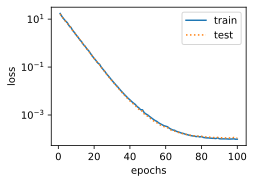

In [8]:
fit_and_plot(poly_features[:n_train, :], 
             poly_features[n_train:, :], 
             labels[:n_train], 
             labels[n_train:]
            )

### 3.11.4.4 线性函数拟合（欠拟合）

我们再试试线性函数拟合。很明显，该模型的训练误差在迭代早期下降后便很难继续降低。在完成最后一次迭代周期后，训练误差依旧很高。线性模型在非线性模型（如三阶多项式函数）生成的数据集上容易欠拟合。

final epoch: train loss 112.76031494140625 test loss 74.93932342529297
weight: tensor([[16.4787]]) 
bias: tensor([3.0688])


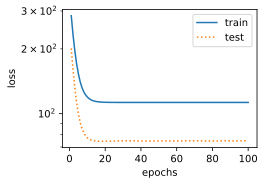

In [9]:

fit_and_plot(features[:n_train, :], 
             features[n_train:, :], 
             labels[:n_train],
             labels[n_train:]
            )

### 3.11.4.5 训练样本不足（过拟合）

事实上，即便使用与数据生成模型同阶的三阶多项式函数模型，如果训练样本不足，该模型依然容易过拟合。让我们只使用两个样本来训练模型。显然，训练样本过少了，甚至少于模型参数的数量。这使模型显得过于复杂，以至于容易被训练数据中的噪声影响。在迭代过程中，尽管训练误差较低，但是测试数据集上的误差却很高。这是典型的过拟合现象。

final epoch: train loss 1.2583849430084229 test loss 9.048544883728027
weight: tensor([[-0.4445, -2.2836,  6.0610]]) 
bias: tensor([1.3339])


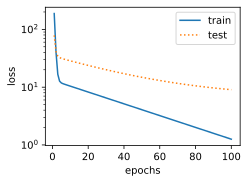

In [10]:

fit_and_plot(poly_features[0:2, :], 
             poly_features[n_train:, :], 
             labels[0:2],
             labels[n_train:]
            )

我们将在接下来的两个小节继续讨论 过拟合问题 以及 应对过拟合的方法。


## 小结

* 由于无法从训练误差估计泛化误差，一味地降低训练误差并不意味着泛化误差一定会降低。机器学习模型应关注降低泛化误差。
* 可以使用验证数据集来进行模型选择。
* 欠拟合指模型无法得到较低的训练误差，过拟合指模型的训练误差远小于它在测试数据集上的误差。
* 应选择复杂度合适的模型并避免使用过少的训练样本。